In [3]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import os
from tensorflow import keras
from tensorflow.keras import layers # type: ignore
# from datetime import datetime
import cv2
# import time

2025-05-03 10:21:14.335456: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746267675.665061  119277 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746267676.023614  119277 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1746267679.275023  119277 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1746267679.275053  119277 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1746267679.275054  119277 computation_placer.cc:177] computation placer alr

# Import Data

In [7]:
data_train_path='./dataset/newDatasetSplit/train'
data_test_path='./dataset/newDatasetSplit/test'
data_val_path='./dataset/newDatasetSplit/val'

In [8]:
img_width = 180
img_height = 180

In [9]:
data_val = tf.keras.utils.image_dataset_from_directory(
    data_val_path,
    shuffle=True,
    image_size=(img_width,img_height),
    batch_size = 32,
    validation_split=False
)

Found 3675 files belonging to 25 classes.


In [10]:
data_train = tf.keras.utils.image_dataset_from_directory(
    data_train_path,
    shuffle=True,
    image_size=(img_width,img_height),
    batch_size = 32,
    validation_split=False
)

Found 17125 files belonging to 25 classes.


In [11]:
data_cat = data_train.class_names
print(data_cat)

['00', '01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '24', '25']


In [12]:
data_test = tf.keras.utils.image_dataset_from_directory(
    data_test_path,
    shuffle=True,
    image_size=(img_width,img_height),
    batch_size = 32,
    validation_split=False
)

Found 3700 files belonging to 25 classes.


2025-05-03 09:08:48.007492: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


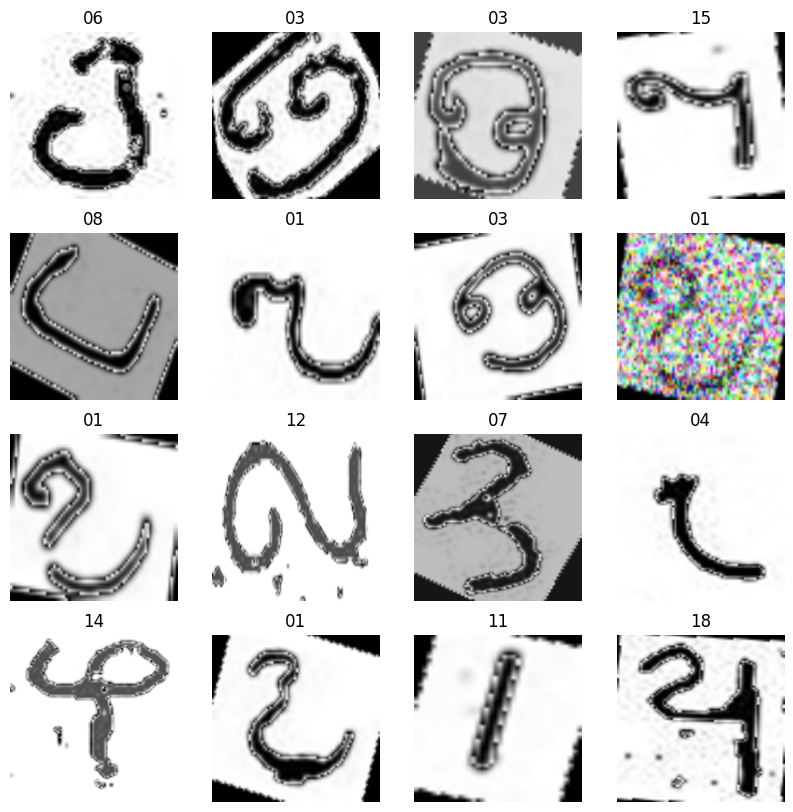

In [8]:
plt.figure(figsize=(10,10))
for image, labels in data_train.take(1):
    for i in range(16):
        plt.subplot(4,4,i+1)
        plt.imshow(image[i].numpy().astype('uint8'))
        plt.title(data_cat[labels[i]])
        plt.axis('off')

# Building Model

In [9]:
from tensorflow.keras.models import Sequential # type: ignore

## Checking GPU

In [10]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

Physical devices cannot be modified after being initialized


## Pushing Model in GPU

In [17]:
gpus = tf.config.experimental.list_physical_devices('GPU')

if gpus:
    # Print GPU details
    print(f"Using GPU: {tf.config.experimental.get_device_details(gpus[0])['device_name']}")
    with tf.device('/GPU:0'):
        # Define your model architecture
        model = Sequential([
        layers.Rescaling(1./255),
        layers.Conv2D(16, 3, padding='same', activation='relu'),
        layers.MaxPooling2D(),
        layers.Conv2D(32,3, padding='same',activation='relu'),
        layers.MaxPooling2D(),
        layers.Conv2D(64, 3, padding='same', activation='relu'),
        layers.MaxPooling2D(),
        layers.Flatten(),
        layers.Dropout(0.2),
        layers.Dense(128),
        layers.Dense(len(data_cat))

    ])

        # Compile the model
        model.compile(optimizer='adam',
                      loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                      metrics=['accuracy'])
else:
    print("No GPU detected, running on CPU.")
    model = Sequential([
        layers.Rescaling(1./255),
        layers.Conv2D(16, 3, padding='same', activation='relu'),
        layers.MaxPooling2D(),
        layers.Conv2D(32,3, padding='same',activation='relu'),
        layers.MaxPooling2D(),
        layers.Conv2D(64, 3, padding='same', activation='relu'),
        layers.MaxPooling2D(),
        layers.Flatten(),
        layers.Dropout(0.2),
        layers.Dense(128),
        layers.Dense(len(data_cat))
    ])

    # Compile the model
    model.compile(optimizer='adam',
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                  metrics=['accuracy'])

# # Custom F1-score metric
# def f1_score(y_true, y_pred):
#     y_pred = tf.argmax(y_pred, axis=1)
#     y_true = tf.cast(y_true, tf.int64)

#     precision = tf.keras.metrics.Precision()(y_true, y_pred)
#     recall = tf.keras.metrics.Recall()(y_true, y_pred)

#     return 2 * ((precision * recall) / (precision + recall + K.epsilon()))

# # Detect available GPUs
# gpus = tf.config.experimental.list_physical_devices('GPU')

# if gpus:
#     print(f"Using GPU: {tf.config.experimental.get_device_details(gpus[0])['device_name']}")
#     with tf.device('/GPU:0'):
#         model = Sequential([
#             layers.Rescaling(1./255),
#             layers.Conv2D(16, 3, padding='same', activation='relu'),
#             layers.MaxPooling2D(),
#             layers.Conv2D(32, 3, padding='same', activation='relu'),
#             layers.MaxPooling2D(),
#             layers.Conv2D(64, 3, padding='same', activation='relu'),
#             layers.MaxPooling2D(),
#             layers.Flatten(),
#             layers.Dropout(0.2),
#             layers.Dense(128, activation='relu'),
#             layers.Dense(len(data_cat))  # Make sure data_cat is defined
#         ])
#         model.compile(
#             optimizer='adam',
#             loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
#             metrics=['accuracy', f1_score]
#         )
# else:
#     print("No GPU detected, running on CPU.")
#     model = Sequential([
#         layers.Rescaling(1./255),
#         layers.Conv2D(16, 3, padding='same', activation='relu'),
#         layers.MaxPooling2D(),
#         layers.Conv2D(32, 3, padding='same', activation='relu'),
#         layers.MaxPooling2D(),
#         layers.Conv2D(64, 3, padding='same', activation='relu'),
#         layers.MaxPooling2D(),
#         layers.Flatten(),
#         layers.Dropout(0.2),
#         layers.Dense(128, activation='relu'),
#         layers.Dense(len(data_cat))
#     ])
#     model.compile(
#         optimizer='adam',
#         loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
#         metrics=['accuracy', f1_score]
#     )

Using GPU: NVIDIA GeForce RTX 3050 Laptop GPU


## Import Model module

In [20]:
from tensorflow.keras.models import Model # type: ignore
from tensorflow.keras.models import load_model # type: ignore
from sklearn.metrics import f1_score
epochs_size = 32

### Fitting Data , Training & Plotting

Epoch 1/32
536/536 ━━━━━━━━━━━━━━━━━━━━ 15s 28ms/step - accuracy: 0.9984 - loss: 0.0088 - val_accuracy: 0.9829 - val_loss: 0.1317
Epoch 2/32
536/536 ━━━━━━━━━━━━━━━━━━━━ 15s 29ms/step - accuracy: 0.9984 - loss: 0.0069 - val_accuracy: 0.9829 - val_loss: 0.1261
Epoch 3/32
536/536 ━━━━━━━━━━━━━━━━━━━━ 15s 29ms/step - accuracy: 0.9976 - loss: 0.0090 - val_accuracy: 0.9820 - val_loss: 0.1150
Epoch 4/32
536/536 ━━━━━━━━━━━━━━━━━━━━ 16s 30ms/step - accuracy: 0.9990 - loss: 0.0040 - val_accuracy: 0.9818 - val_loss: 0.1280
Epoch 5/32
536/536 ━━━━━━━━━━━━━━━━━━━━ 16s 30ms/step - accuracy: 0.9981 - loss: 0.0083 - val_accuracy: 0.9807 - val_loss: 0.1328
Epoch 6/32
536/536 ━━━━━━━━━━━━━━━━━━━━ 20s 36ms/step - accuracy: 0.9990 - loss: 0.0093 - val_accuracy: 0.9804 - val_loss: 0.1517
Epoch 7/32
536/536 ━━━━━━━━━━━━━━━━━━━━ 17s 32ms/step - accuracy: 0.9982 - loss: 0.0065 - val_accuracy: 0.9856 - val_loss: 0.1023
Epoch 8/32
536/536 ━━━━━━━━━━━━━━━━━━━━ 18s 34ms/step - accuracy: 0.9991 - loss: 0.0043 - 

Text(0.5, 1.0, 'Loss')

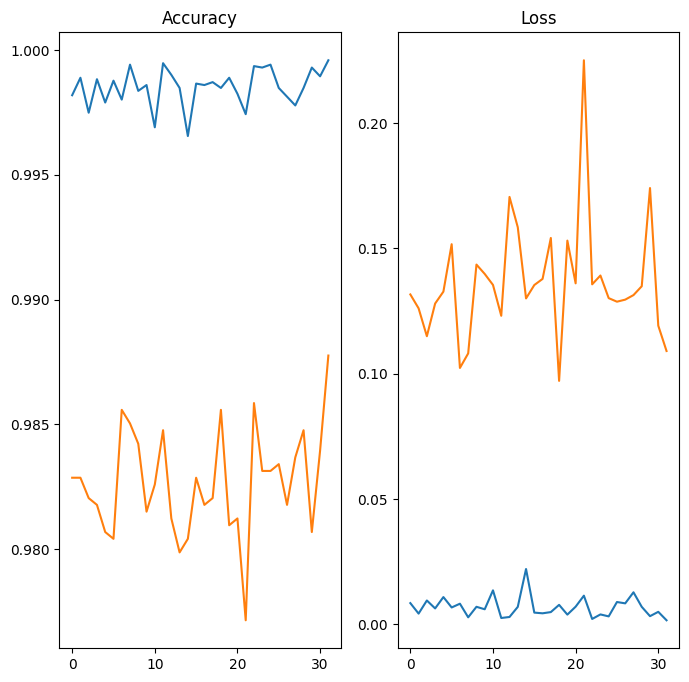

In [30]:
history = model.fit(data_train,validation_data=data_val, epochs=epochs_size)

# Plotting in Graph
epochs_range = range(epochs_size)
plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(epochs_range,history.history['accuracy'],label = 'Training Accuracy')
plt.plot(epochs_range,history.history['val_accuracy'],label = 'Validation Accuracy')
plt.title('Accuracy')

plt.subplot(1,2,2)
plt.plot(epochs_range,history.history['loss'],label = 'Training Loss')
plt.plot(epochs_range, history.history['val_loss'],label = 'Validation Loss')
plt.title('Loss')

In [4]:
# Get predictions on validation set
y_pred_probs = model.predict(data_val)
y_pred = np.argmax(y_pred_probs, axis=1)

# Extract true labels from validation data
try:
    # For Keras ImageDataGenerator or similar
    y_true = data_val.classes
except AttributeError:
    # For tf.data.Dataset or custom generator
    y_true = np.concatenate([y for x, y in data_val], axis=0)

# Compute F1 Score
f1 = f1_score(y_true, y_pred, average='weighted')  # Can change to 'macro' if needed

print(f"Final Weighted F1 Score: {f1:.4f}")


KeyboardInterrupt



### Save MODEL

In [ ]:
# save model
model.save('cnnModel.h5')
print('Model Saved!')

Model Saved!


# Model 2

Classes: ['00', '01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '24', '25']
Epoch [1/10], Loss: 259.2432, Train Acc: 86.34%, Val Acc: 98.07%
Epoch [2/10], Loss: 26.5307, Train Acc: 98.54%, Val Acc: 99.02%
Epoch [3/10], Loss: 12.3963, Train Acc: 99.24%, Val Acc: 99.73%
Epoch [4/10], Loss: 4.4423, Train Acc: 99.75%, Val Acc: 99.46%
Epoch [5/10], Loss: 10.4002, Train Acc: 99.61%, Val Acc: 99.32%
Epoch [6/10], Loss: 18.5396, Train Acc: 99.03%, Val Acc: 99.48%
Epoch [7/10], Loss: 6.9168, Train Acc: 99.60%, Val Acc: 99.84%
Epoch [8/10], Loss: 2.5241, Train Acc: 99.85%, Val Acc: 99.70%
Epoch [9/10], Loss: 9.8947, Train Acc: 99.45%, Val Acc: 99.40%
Epoch [10/10], Loss: 3.0336, Train Acc: 99.83%, Val Acc: 99.92%


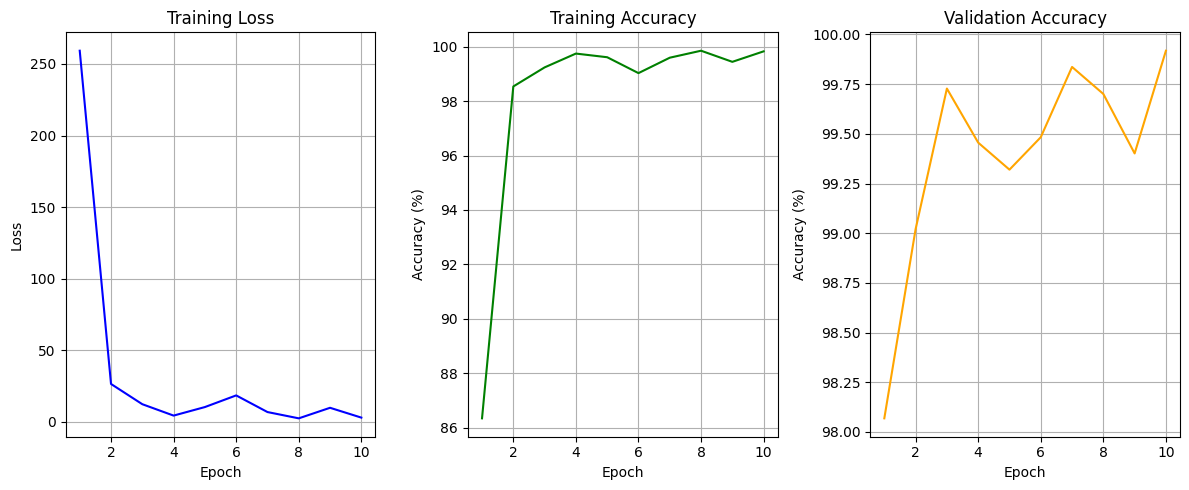

### load model

In [5]:
# f1 score
from tensorflow.keras.models import load_model
from sklearn.metrics import f1_score
import numpy as np

# 1. Load the saved model
savedModel = load_model('./cnnModelgpu.h5')

# 2. Get predictions on validation/test data
y_pred_probs = saved_model.predict(data_val)  # data_val must be the same format as during training
y_pred = np.argmax(y_pred_probs, axis=1)

# 3. Extract true labels
try:
    # If using ImageDataGenerator or similar
    y_true = data_val.classes
except AttributeError:
    # If using tf.data.Dataset
    y_true = np.concatenate([y for x, y in data_val], axis=0)

# 4. Compute F1 score
f1 = f1_score(y_true, y_pred, average='macro')  # or 'macro' as needed

print(f"Final Weighted F1 Score from saved model: {f1:.4f}")


I0000 00:00:1746267769.256483  119277 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 1767 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3050 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6


NameError: name 'saved_model' is not defined

In [ ]:
# savedModel=load_model('./cnnModelgpu.h5')
# savedModel.summary()
savedModel = torch.load('./mobilenetv3_old_tamil.pth', map_location=device)
print(savedModel)

OrderedDict({'conv_stem.weight': tensor([[[[ 2.4686e-02,  2.9730e-02,  2.8654e-02],
          [ 3.0236e-02,  3.3604e-02,  2.9748e-02],
          [ 2.6463e-02,  2.3598e-02,  2.0512e-02]],

         [[-1.7137e-02, -1.8530e-02, -9.6692e-03],
          [-2.5525e-02, -3.1428e-02, -2.3131e-02],
          [-1.9600e-02, -3.1381e-02, -2.1227e-02]],

         [[ 7.8891e-03,  1.0038e-02,  1.3918e-02],
          [ 8.2255e-03,  9.6059e-03,  1.0040e-02],
          [ 8.7862e-03,  5.2524e-03,  3.8640e-03]]],


        [[[ 2.6695e-02,  3.2137e-02,  2.6560e-02],
          [ 3.5727e-02,  4.4943e-02,  3.6265e-02],
          [ 2.8448e-02,  4.3565e-02,  3.1197e-02]],

         [[-5.0655e-04, -5.3054e-03, -1.0948e-02],
          [-5.5407e-04,  5.7221e-04,  3.4328e-03],
          [-4.2402e-03,  1.2122e-02,  1.0125e-02]],

         [[-2.1596e-02, -2.1331e-02, -2.2652e-02],
          [-2.3265e-02, -2.5182e-02, -2.0850e-02],
          [-2.4677e-02, -2.0057e-02, -1.7737e-02]]],


        [[[-1.2556e-02,  2.1026e-

## Using Image File

Predicted category: 11 with accuracy: 39.66%


NameError: name 'reference_dir' is not defined

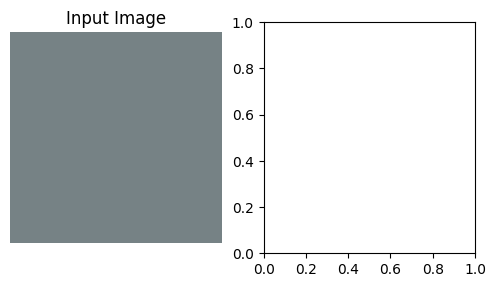

In [ ]:
from PIL import Image
import os
input_dir = './segmented_characters'
reference_dir = './dataset/OneDrive_2025-03-20/New mapping'  # Define the reference directory
img_files = [f for f in os.listdir(input_dir) if f.lower().endswith(('png', 'jpg', 'jpeg'))]
img_files.sort()  # Sort for consistent order
total_images = len(img_files)

for i in range(total_images):
    image_path = os.path.join(input_dir, img_files[i])

    try:
        image = Image.open(image_path).convert("RGB")
    except Exception as e:
        print(f"Skipping {img_files[i]}: {e}")
        continue

    # Apply transform
    img_tensor = transform(image).unsqueeze(0).to(device)

    # Predict
    with torch.no_grad():
        output = model(img_tensor)
        prob = torch.nn.functional.softmax(output[0], dim=0)
        predicted_category = torch.argmax(prob).item()
        accuracy = prob[predicted_category].item() * 100

    predicted_label = data_cat[predicted_category]
    print(f"Predicted category: {predicted_label} with accuracy: {accuracy:.2f}%")

    # Plot original and reference side by side
    fig, axs = plt.subplots(1, 2, figsize=(6, 3))
    axs[0].imshow(image)
    axs[0].set_title("Input Image")
    axs[0].axis('off')

    # Load corresponding reference image
    ref_img_path = os.path.join(reference_dir, predicted_label, f"{predicted_label}.png")
    if os.path.exists(ref_img_path):
        ref_img = Image.open(ref_img_path).resize((img_width, img_height))
        axs[1].imshow(ref_img)
        axs[1].set_title(f"Predicted: {predicted_label}")
        axs[1].axis('off')
        ref_img.close()
    else:
        axs[1].text(0.5, 0.5, "No ref image", ha='center', va='center')
        axs[1].axis('off')

    plt.suptitle(f"Accuracy: {accuracy:.2f}%", fontsize=10)
    plt.tight_layout()
    plt.show()

I0000 00:00:1746268002.539468  120420 service.cc:152] XLA service 0x7f9c5c005d90 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1746268002.539501  120420 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce RTX 3050 Laptop GPU, Compute Capability 8.6
2025-05-03 10:26:42.817458: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1746268003.080485  120420 cuda_dnn.cc:529] Loaded cuDNN version 90501


1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
Predicted category:  05  with accuracy:  100.0
Accuracy:  100.0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


I0000 00:00:1746268008.651412  120420 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


Predicted category:  05  with accuracy:  99.999916
Accuracy:  99.999916
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Predicted category:  05  with accuracy:  99.984535
Accuracy:  99.984535
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Predicted category:  05  with accuracy:  100.0
Accuracy:  100.0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Predicted category:  05  with accuracy:  100.0
Accuracy:  100.0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Predicted category:  05  with accuracy:  100.0
Accuracy:  100.0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Predicted category:  05  with accuracy:  100.0
Accuracy:  100.0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Predicted category:  05  with accuracy:  99.99983
Accuracy:  99.99983
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Predicted category:  05  with accuracy:  100.0
Accuracy:  100.0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Predicted category:  06  with accuracy:  99.99951
Accuracy:  99.99951
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Predicted category:  04  with accuracy:  72.75511
Accu

/tmp/ipykernel_119277/1278890069.py:21: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(10, 10))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Predicted category:  05  with accuracy:  100.0
Accuracy:  100.0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Predicted category:  05  with accuracy:  99.96376
Accuracy:  99.96376
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Predicted category:  04  with accuracy:  68.66137
Accuracy:  68.66137
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Predicted category:  05  with accuracy:  99.999725
Accuracy:  99.999725
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Predicted category:  06  with accuracy:  99.847
Accuracy:  99.847
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Predicted category:  05  with accuracy:  99.14263
Accuracy:  99.14263
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Predicted category:  05  with accuracy:  99.999985
Accuracy:  99.999985
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Predicted category:  05  with accuracy:  100.0
Accuracy:  100.0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Predicted category:  02  with accuracy:  100.0
Accuracy:  100.0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Predicte

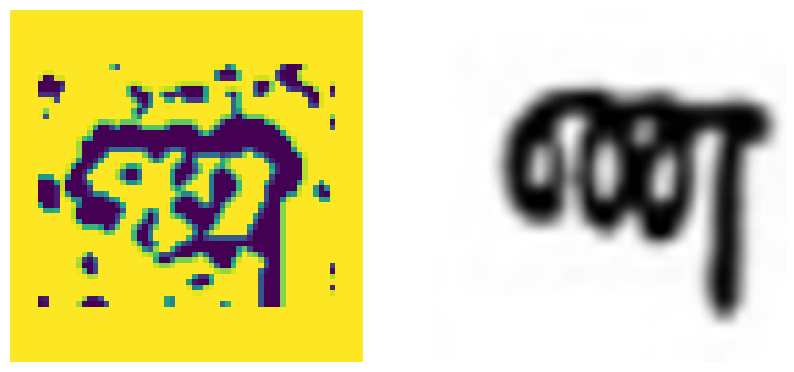

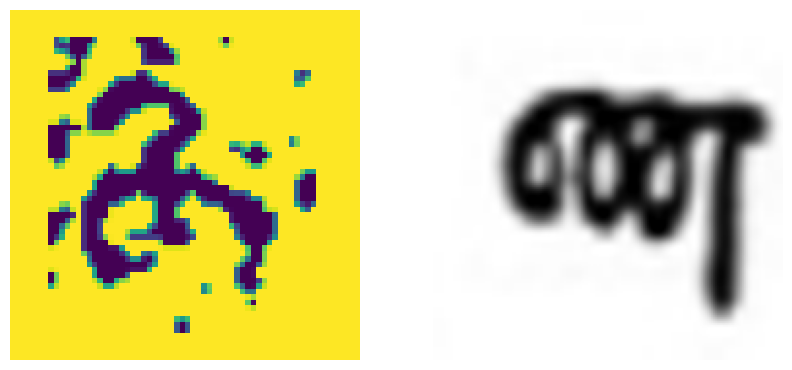

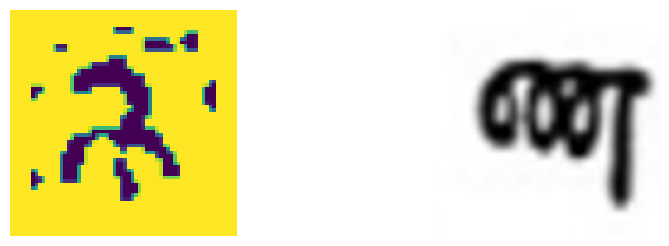

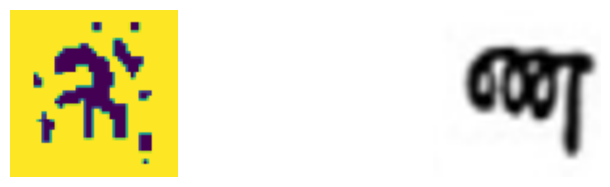

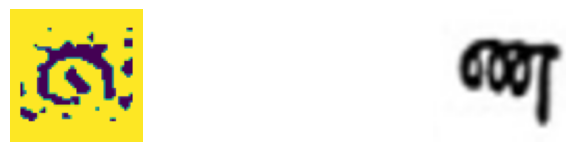

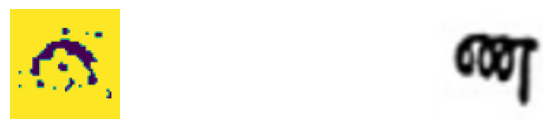

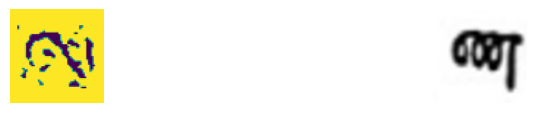

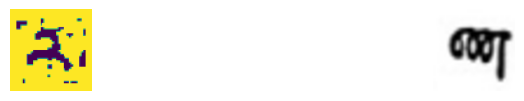

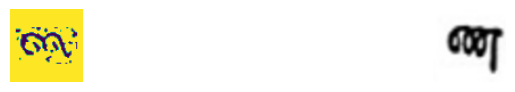

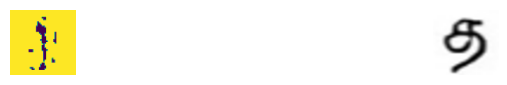

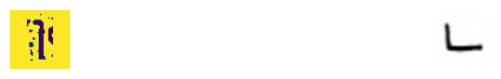

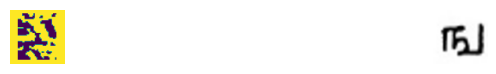

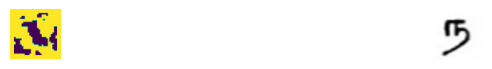

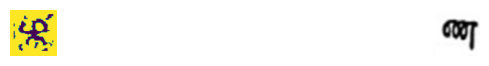

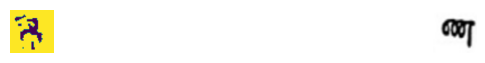

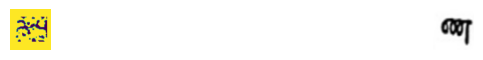

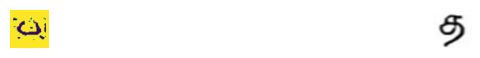

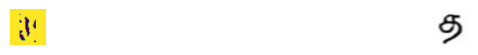

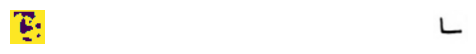

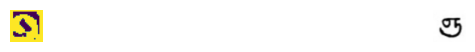

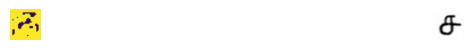

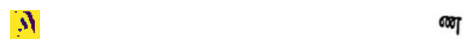

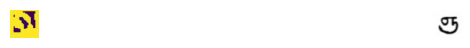

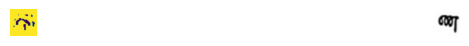

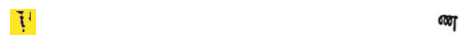

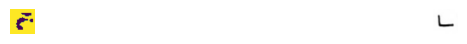

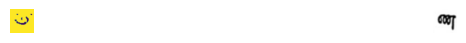

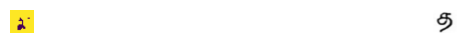

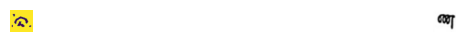

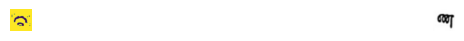

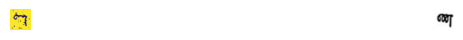

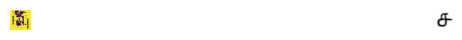

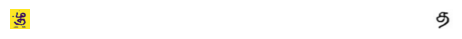

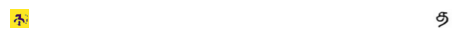

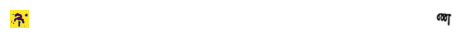

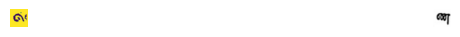

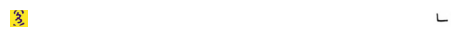

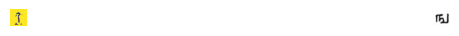

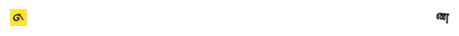

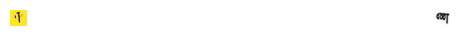

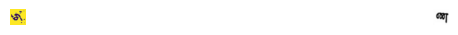

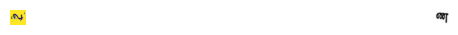

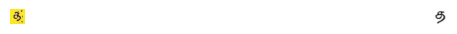

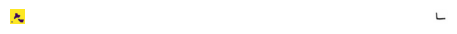

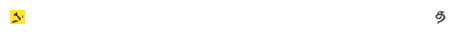

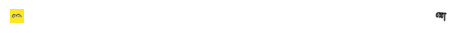

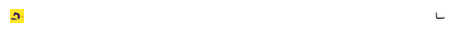

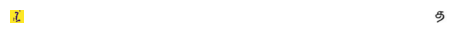

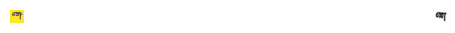

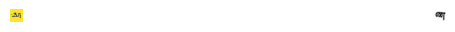

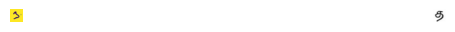

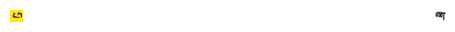

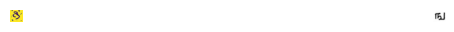

In [13]:
from PIL import Image
import os
input_dir = './segmented_scattered_characters'
img_files = [f for f in os.listdir(input_dir) if f.lower().endswith(('png', 'jpg', 'jpeg'))]
total_images = len(img_files)

for i in range(1,total_images - 1):
        image_path = os.path.join(input_dir, img_files[i])
        image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
        image = tf.keras.utils.load_img(image_path, target_size=(img_height, img_width))
        img_array = tf.keras.utils.img_to_array(image)
        img_array = tf.expand_dims(img_array, 0)  # Create a batch

        # Normalize pixel values to be between 0 and 1
        img_bat = img_array
        predict = savedModel.predict(img_bat)
        score = tf.nn.softmax(predict)
        predicted_category = np.argmax(score)
        accuracy = np.max(score) * 100
        print("Predicted category: ", data_cat[predicted_category], " with accuracy: ", accuracy)
        plt.figure(figsize=(10, 10))
        plt.subplot(i, 2, 1)
        img = Image.open(image_path)
        plt.imshow(img)
        plt.axis('off')

        plt.subplot(i, 2, 2)
        img = Image.open(f"./dataset/OneDrive_2025-03-20/New mapping/{data_cat[predicted_category]}/{data_cat[predicted_category]}.png")
        img = img.resize((img_width, img_height))  # Resize the image to match target size
        plt.imshow(img)
        plt.axis('off')
        print("Accuracy: ", accuracy)
        img.close()
        # Check if the image is None
        if image is None:
            print(f"Skipping {img_files[i]}: Not a valid image.")
            continue
